# Fraud Detection - Model Training & Evaluation

This notebook focuses on training and evaluating machine learning models for the IEEE-CIS Fraud Detection task.

## Why Tree-Based Models?

Tree-based ensemble methods are particularly well-suited for fraud detection due to:

1. **Robustness to Feature Distributions**: No assumptions about normality; handles skewed transaction amounts naturally
2. **Missing Value Handling**: Native support for missing values (especially LightGBM, XGBoost)
3. **Feature Interactions**: Automatically captures non-linear relationships and complex interactions
4. **Imbalanced Data**: Built-in mechanisms (`scale_pos_weight`, `is_unbalance`) for class imbalance
5. **Correlation Insensitivity**: Unlike linear models, not affected by multicollinearity
6. **Outlier Robustness**: Split-based decisions are less sensitive to extreme values
7. **Mixed Feature Types**: Handles both numerical and encoded categorical features seamlessly

**Models to Compare**:
1. Random Forest - Bagging ensemble, robust baseline
2. XGBoost - Gradient boosting with regularization
3. LightGBM - Fast gradient boosting, leaf-wise growth
4. CatBoost - Native categorical handling, ordered boosting
5. **Stacking Ensemble** - Combines base models for improved performance

**Evaluation Strategy**: 
- Stratified 5-Fold Cross-Validation for OOF predictions
- Stacking uses OOF predictions to avoid data leakage
- Primary metric: ROC-AUC (standard for fraud detection)

In [30]:
# =============================================================================
# Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Custom functions
import sys
ROOT = Path.cwd().parent
sys.path.append(str(ROOT / "functions"))

from model_functions import (
    compare_roc_curves, compare_models, plot_feature_importance,
    full_evaluation_report, find_optimal_threshold
)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Data & Configuration

In [31]:
# =============================================================================
# Load Preprocessed Data from EDA.ipynb
# =============================================================================
import pickle

DATA = ROOT / "data"

# Load DataFrames
train_df = pd.read_parquet(DATA / "train_preprocessed.parquet")
test_df = pd.read_parquet(DATA / "test_preprocessed.parquet")

# Load feature lists
with open(DATA / "feature_lists.pkl", 'rb') as f:
    feature_lists = pickle.load(f)

filtered_features = feature_lists['filtered_features']
categorical_features = feature_lists['categorical_for_model']
strong_features = feature_lists['strong_features']
moderate_features = feature_lists['moderate_features']

print(f"✅ Data loaded successfully!")
print(f"   Train shape: {train_df.shape}")
print(f"   Test shape: {test_df.shape}")
print(f"   Features for modeling: {len(filtered_features)}")

✅ Data loaded successfully!
   Train shape: (472432, 195)
   Test shape: (118108, 195)
   Features for modeling: 175


In [ ]:
# =============================================================================
# Prepare Features and Target
# =============================================================================
X_train = train_df[filtered_features].copy()
y_train = train_df['isFraud'].copy()
X_test = test_df[filtered_features].copy()
y_test = test_df['isFraud'].copy()

# =============================================================================
# Handle Infinity and Missing Values
# =============================================================================
inf_cols = X_train.columns[X_train.isin([np.inf, -np.inf]).any()].tolist()
if inf_cols:
    print(f" Found infinity in {len(inf_cols)} columns: {inf_cols}")

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

MISSING_FLAG = -222  # yarışma birincisinin uygulamasında -999 kullanılmış böylece ağaç algoritmalarında bu kayıtlar direkt ayrılıyor
X_train = X_train.fillna(MISSING_FLAG)
X_test = X_test.fillna(MISSING_FLAG)

print(f"   Data prepared: X_train {X_train.shape}, X_test {X_test.shape}")
print(f"   Train fraud rate: {y_train.mean()*100:.2f}%")
print(f"   Test fraud rate: {y_test.mean()*100:.2f}%")

✅ Data prepared: X_train (472432, 175), X_test (118108, 175)
   Train fraud rate: 3.51%
   Test fraud rate: 3.44%


## 2. Model Definitions & Stacking Configuration

In [ ]:
# =============================================================================
# STACKING CONFIGURATION
# =============================================================================
# Choose stacking method:
#   'logistic'  - Logistic Regression as meta-model (recommended for probability calibration)
#   'ridge'     - Ridge Classifier as meta-model (more regularization)
#   'weighted'  - No meta-model, weighted average based on CV performance

STACKING_METHOD = 'logistic'  # <-- CHANGE THIS TO SWITCH STACKING METHOD

# =============================================================================
# Model Definitions
# =============================================================================
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio (neg/pos): {scale_pos_weight:.2f}")

# Define all base models
BASE_MODELS = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        is_unbalance=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        auto_class_weights='Balanced',
        eval_metric='AUC',
        random_seed=42,
        verbose=0
    )
}

print(f"   {len(BASE_MODELS)} base models defined")
print(f"   Stacking method: {STACKING_METHOD}")

Class imbalance ratio (neg/pos): 27.46
✅ 4 base models defined
   Stacking method: logistic


## 3. Train All Models with OOF Predictions

Train all base models using Stratified K-Fold CV to generate out-of-fold (OOF) predictions.
These OOF predictions are used for:
1. Evaluating individual model performance
2. Training the stacking meta-model (without data leakage)

In [34]:
# =============================================================================
# Train All Base Models with OOF Predictions
# =============================================================================
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Storage for OOF predictions and test predictions
oof_predictions = {name: np.zeros(len(y_train)) for name in BASE_MODELS}
test_predictions = {name: np.zeros(len(y_test)) for name in BASE_MODELS}
cv_scores = {name: [] for name in BASE_MODELS}
trained_models = {name: [] for name in BASE_MODELS}  # Store fold models

print(f"Training {len(BASE_MODELS)} models with {N_FOLDS}-Fold CV...")
print("=" * 60)

for model_name, model in BASE_MODELS.items():
    print(f"\n▶ Training {model_name}...")
    start_time = time.time()
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Clone and train model
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_tr, y_tr)
        
        # OOF predictions
        val_probs = model_clone.predict_proba(X_val)[:, 1]
        oof_predictions[model_name][val_idx] = val_probs
        
        # Test predictions (average across folds)
        test_predictions[model_name] += model_clone.predict_proba(X_test)[:, 1] / N_FOLDS
        
        # Store fold score
        fold_auc = roc_auc_score(y_val, val_probs)
        cv_scores[model_name].append(fold_auc)
        
        # Store trained model (for feature importance later)
        trained_models[model_name].append(model_clone)
    
    # Calculate training time
    elapsed_time = time.time() - start_time
    
    # Print CV results
    mean_auc = np.mean(cv_scores[model_name])
    std_auc = np.std(cv_scores[model_name])
    print(f"   CV AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"   Training time: {elapsed_time:.2f} seconds")



Training 4 models with 5-Fold CV...

▶ Training RandomForest...
   CV AUC: 0.9380 ± 0.0015
   Training time: 344.71 seconds

▶ Training XGBoost...
   CV AUC: 0.9424 ± 0.0023
   Training time: 639.76 seconds

▶ Training LightGBM...
   CV AUC: 0.9411 ± 0.0023
   Training time: 65.59 seconds

▶ Training CatBoost...
   CV AUC: 0.9196 ± 0.0020
   Training time: 193.61 seconds

✅ All base models trained!


## 4. Stacking Ensemble

Combine base model predictions using the configured stacking method.

In [42]:
# =============================================================================
# Build Stacking Ensemble
# =============================================================================

# Create meta-features from OOF predictions
meta_train = np.column_stack([oof_predictions[name] for name in BASE_MODELS])
meta_test = np.column_stack([test_predictions[name] for name in BASE_MODELS])

print(f"Meta-features shape: Train {meta_train.shape}, Test {meta_test.shape}")
print(f"Stacking method: {STACKING_METHOD}")

STACKING_METHOD = 'weighted'

if STACKING_METHOD == 'logistic':
    # Logistic Regression meta-model
    meta_model = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
    # Scale meta-features for logistic regression
    scaler = StandardScaler()
    meta_train_scaled = scaler.fit_transform(meta_train)
    meta_test_scaled = scaler.transform(meta_test)
    
    meta_model.fit(meta_train_scaled, y_train)
    stacking_probs = meta_model.predict_proba(meta_test_scaled)[:, 1]
    stacking_oof = meta_model.predict_proba(scaler.transform(meta_train))[:, 1]
    
    print(f"Meta-model coefficients: {dict(zip(BASE_MODELS.keys(), meta_model.coef_[0].round(3)))}")

elif STACKING_METHOD == 'ridge':
    # Ridge Classifier meta-model
    meta_model = RidgeClassifier(
        class_weight='balanced',
        random_state=42
    )
    scaler = StandardScaler()
    meta_train_scaled = scaler.fit_transform(meta_train)
    meta_test_scaled = scaler.transform(meta_test)
    
    meta_model.fit(meta_train_scaled, y_train)
    # Ridge doesn't have predict_proba, use decision_function
    stacking_probs = meta_model.decision_function(meta_test_scaled)
    stacking_oof = meta_model.decision_function(scaler.transform(meta_train))
    # Normalize to [0, 1] range for comparison
    stacking_probs = (stacking_probs - stacking_probs.min()) / (stacking_probs.max() - stacking_probs.min())
    stacking_oof = (stacking_oof - stacking_oof.min()) / (stacking_oof.max() - stacking_oof.min())
    
    print(f"Meta-model coefficients: {dict(zip(BASE_MODELS.keys(), meta_model.coef_[0].round(3)))}")

elif STACKING_METHOD == 'weighted':
    # Weighted average based on CV performance
    cv_aucs = {name: np.mean(cv_scores[name]) for name in BASE_MODELS}
    total_auc = sum(cv_aucs.values())
    weights = {name: auc / total_auc for name, auc in cv_aucs.items()}
    
    print(f"Weights based on CV AUC: {dict((k, round(v, 3)) for k, v in weights.items())}")
    
    stacking_probs = np.zeros(len(y_test))
    stacking_oof = np.zeros(len(y_train))
    for name in BASE_MODELS:
        stacking_probs += test_predictions[name] * weights[name]
        stacking_oof += oof_predictions[name] * weights[name]

else:
    raise ValueError(f"Unknown stacking method: {STACKING_METHOD}")

# Store stacking predictions
test_predictions['Stacking'] = stacking_probs
oof_predictions['Stacking'] = stacking_oof

print(f"\n✅ Stacking ensemble created!")
print(f"   Stacking OOF AUC: {roc_auc_score(y_train, stacking_oof):.4f}")

Meta-features shape: Train (472432, 4), Test (118108, 4)
Stacking method: logistic
Weights based on CV AUC: {'RandomForest': 0.251, 'XGBoost': 0.252, 'LightGBM': 0.252, 'CatBoost': 0.246}

✅ Stacking ensemble created!
   Stacking OOF AUC: 0.9400


## 5. Model Evaluation & Comparison

ROC Curve Comparison on Test Set


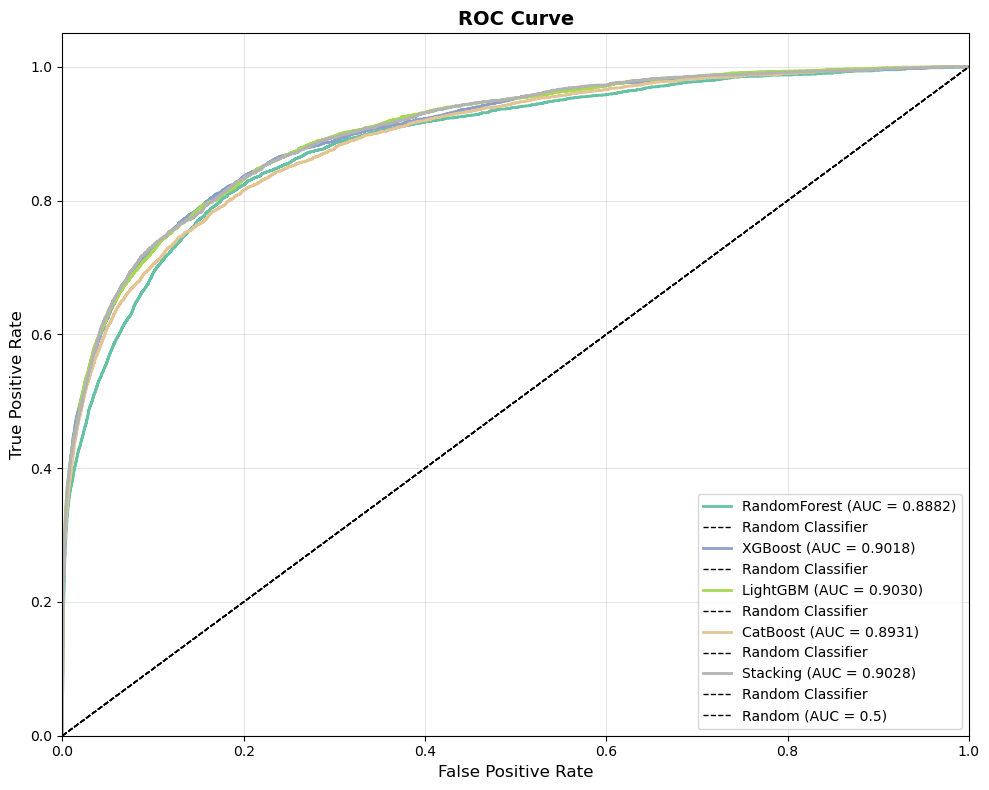

In [43]:
# =============================================================================
# ROC Curve Comparison (All Models)
# =============================================================================
print("ROC Curve Comparison on Test Set")
print("=" * 60)

auc_comparison = compare_roc_curves(y_test, test_predictions)

### Evaluation Metrics Table

Comprehensive comparison of all models with multiple metrics.

In [44]:
# =============================================================================
# Comprehensive Evaluation Table
# =============================================================================
comparison_df = compare_models(y_test, test_predictions, threshold=0.5)

# Add CV scores for base models
cv_summary = []
for name in comparison_df['Model']:
    if name in cv_scores:
        cv_summary.append(f"{np.mean(cv_scores[name]):.4f} ± {np.std(cv_scores[name]):.4f}")
    else:
        cv_summary.append("N/A (ensemble)")

comparison_df['CV AUC (mean ± std)'] = cv_summary

# Reorder columns for better readability
cols_order = ['Model', 'ROC-AUC', 'CV AUC (mean ± std)', 'Avg Precision', 
              'Precision (t=0.5)', 'Recall (t=0.5)', 'F1 (t=0.5)', 
              'Optimal Threshold', 'F1 (optimal)', 'Recall (optimal)']
comparison_df = comparison_df[[c for c in cols_order if c in comparison_df.columns]]

print("=" * 100)
display(comparison_df)

# Highlight best model
best_model = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['ROC-AUC']
print(f"\n Best Model: {best_model} (ROC-AUC: {best_auc:.4f})")


MODEL COMPARISON SUMMARY


,Model,ROC-AUC,CV AUC (mean ± std),Avg Precision,Precision (t=0.5),Recall (t=0.5),F1 (t=0.5),Optimal Threshold,F1 (optimal),Recall (optimal)
0,LightGBM,0.903031,0.9411 ± 0.0023,0.506405,0.206254,0.723917,0.321039,0.397143,0.258207,0.793553
1,Stacking,0.902849,N/A (ensemble),0.499832,0.256764,0.681841,0.373048,0.415684,0.298582,0.753691
2,XGBoost,0.901783,0.9424 ± 0.0023,0.498800,0.276100,0.659203,0.389192,0.302330,0.246821,0.809547
3,CatBoost,0.893110,0.9196 ± 0.0020,0.479854,0.154566,0.763780,0.257103,0.472003,0.243873,0.783465
4,RandomForest,0.888163,0.9380 ± 0.0015,0.446900,0.441412,0.433809,0.437578,0.257027,0.233467,0.810039



 Best Model: LightGBM (ROC-AUC: 0.9030)


## Comparing Stacking Ensemble Approaches

* Ridge : 
    - -> ROC-AUC : 0.8772076345136302
    - -> Avg Precision : 0.481689578620049
    - -> Recall (optimal) : 0.7731299212598425
    - -> F1 : 0.2679172884246429

* Logistic : 
    - ->ROC-AUC : 0.8670163752759331
    - ->Avg Precision :  0.4658784184873924
    - ->Recall (optimal) : 0.7706692913385826
    - -> F1 : 0.2508308973691587

* Weighted : 
    - ->ROC-AUC : 0.9026547712141495
    - ->Avg Precision : 0.4997265235104369
    - ->Recall (optimal) : 0.7937992125984252
    - -> F1 : 0.2640474728872519  , t = 5 olanı : 0.3738330494037479

t = threshold...

## 6. Optional: Detailed Analysis

The following sections provide additional analysis. Uncomment and run as needed.

In [38]:
# =============================================================================
# [OPTIONAL] Full Evaluation Report for Best Model
# =============================================================================
# Uncomment below to run detailed evaluation with confusion matrix, 
# precision-recall curve, and optimal threshold analysis

# best_model_name = comparison_df.iloc[0]['Model']
# best_probs = test_predictions[best_model_name]

# print(f"Full evaluation for: {best_model_name}")
# report = full_evaluation_report(y_test, best_probs, model_name=best_model_name)

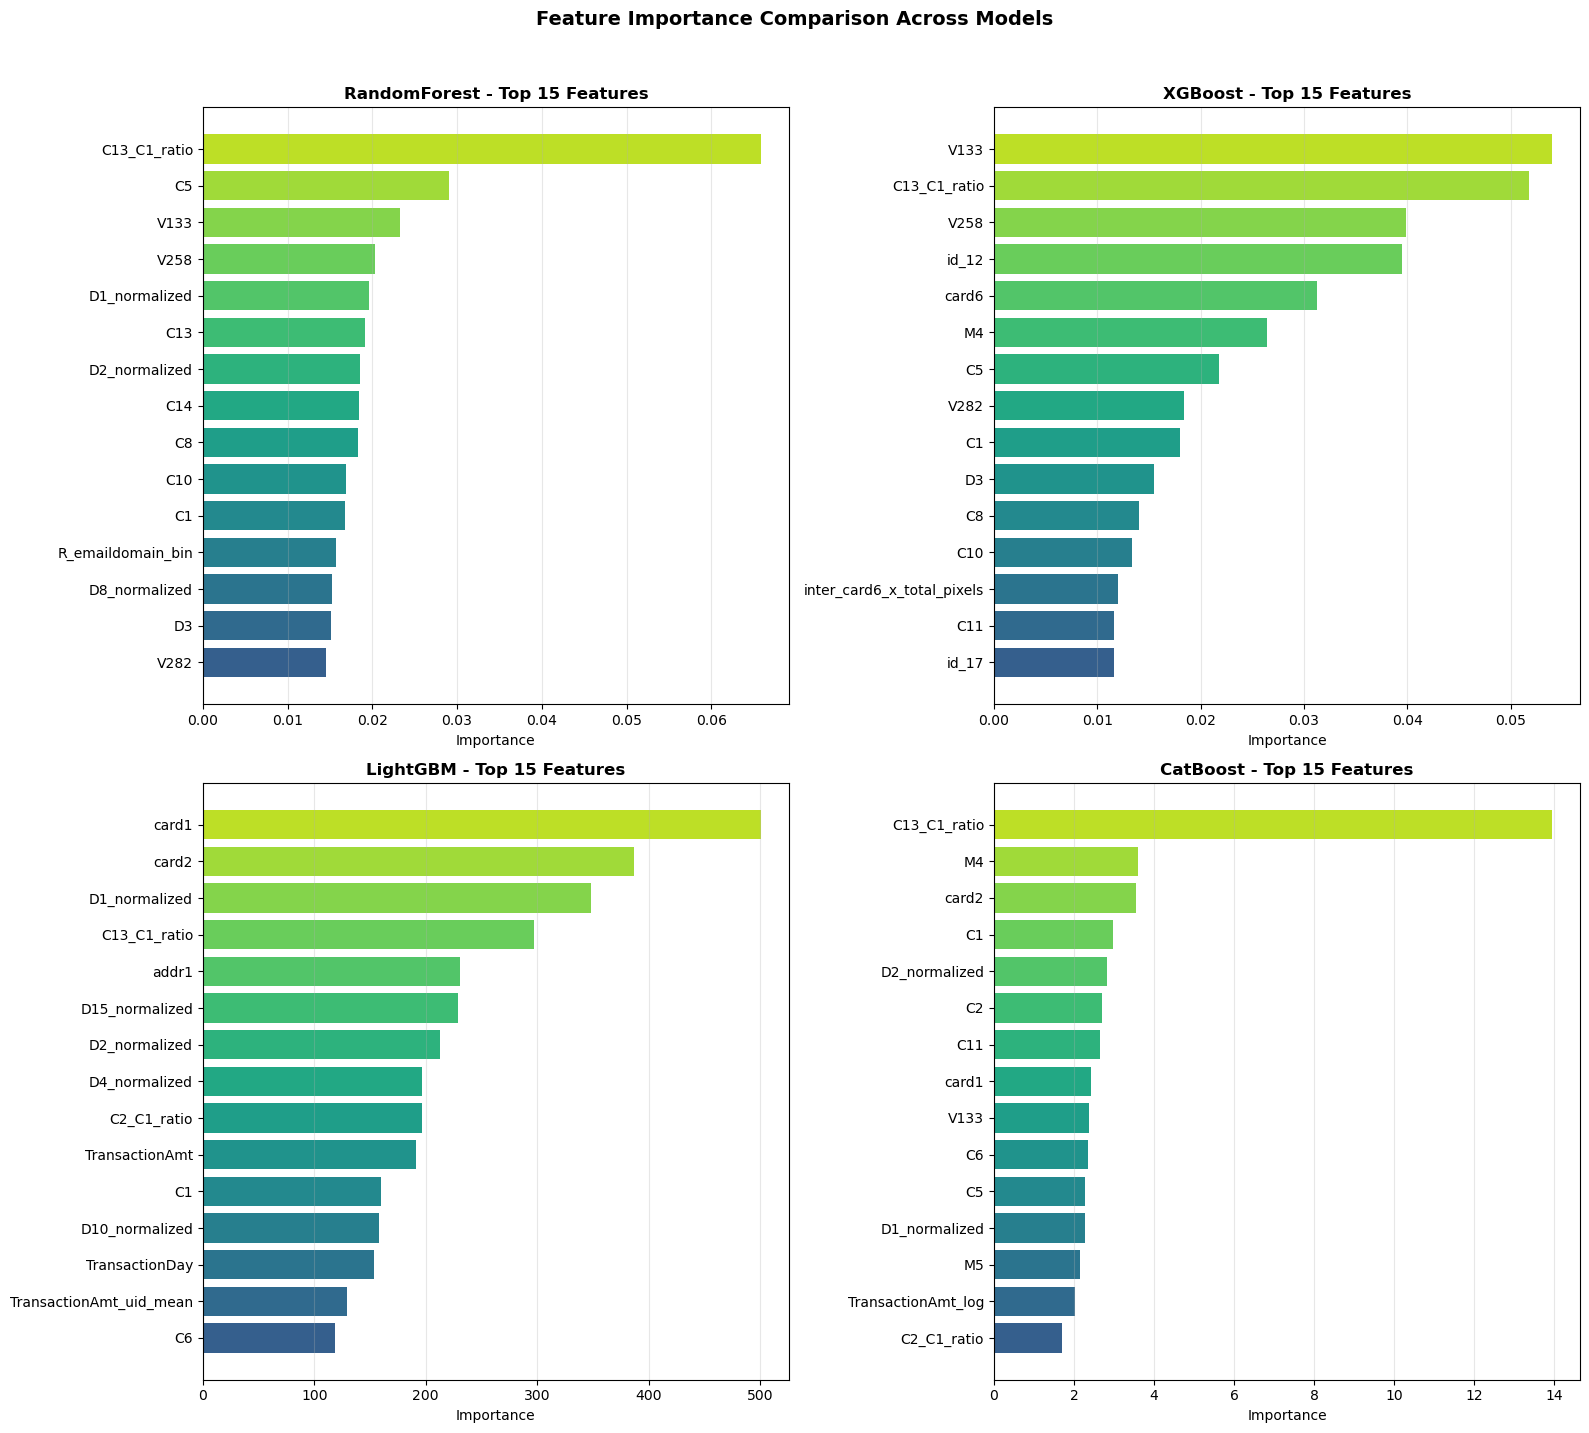

In [39]:
# =============================================================================
# Feature Importance Comparison (All 4 Base Models)
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, model_list) in enumerate(trained_models.items()):
    ax = axes[idx]
    model = model_list[-1]  # Last fold model
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'Feature': filtered_features,
        'Importance': importances
    }).sort_values('Importance', ascending=True).tail(15)  # Top 15
    
    # Plot horizontal bar
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name} - Top 15 Features', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Comparison Across Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [40]:
# =============================================================================
# [OPTIONAL] Optimal Threshold Analysis
# =============================================================================
# Find optimal classification threshold using different methods

# best_model_name = comparison_df.iloc[0]['Model']
# best_probs = test_predictions[best_model_name]
# 
# # Try different threshold optimization methods
# for method in ['youden', 'f1', 'f2']:
#     result = find_optimal_threshold(y_test, best_probs, method=method, plot=False)
#     print(f"{method.upper()}: threshold={result['optimal_threshold']:.4f}, "
#           f"F1={result['f1_at_threshold']:.4f}, Recall={result['recall_at_threshold']:.4f}")

## 7. Save Best Model

In [41]:
# =============================================================================
# Save Models and Predictions (Optional)
# =============================================================================
import joblib

# Uncomment to save:

# Save all trained models
# models_dir = ROOT / "models"
# models_dir.mkdir(exist_ok=True)
# 
# for name, model_list in trained_models.items():
#     joblib.dump(model_list[-1], models_dir / f"{name.lower()}_model.pkl")
# 
# if STACKING_METHOD in ['logistic', 'ridge']:
#     joblib.dump(meta_model, models_dir / f"stacking_meta_{STACKING_METHOD}.pkl")
#     joblib.dump(scaler, models_dir / "stacking_scaler.pkl")
# 
# print(f"✅ Models saved to {models_dir}")